## Задача 5. Обучение без учителя

- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте один из алгоритмов кластеризации, например K-means.
- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из sklearn (KMeans, Affinity Propogation, DBSCAN и тд).
- При обучении использовать подбор гиперпараметров.
 Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- (+3 балла) Также снизить размерность данных с помощью метода главных компонент PCA и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- (+2 балла) Визуализировать данные снижением размерности до 2 или 3 с помощью PCA и t-SNE. В случае проблем с производительностью t-SNE, можно сначала до какой то степени снизить размерность с помощью PCA, а затем запустить t-SNE.

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.base import BaseEstimator, ClusterMixin
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

## Данные

Выберем датасет [Connectionist Bench (Sonar, Mines vs. Rocks)](https://www.kaggle.com/datasets/armanakbari/connectionist-bench-sonar-mines-vs-rocks) с Kaggle.


Описание: "*This is the data set used by Gorman and Sejnowski in their study
of the classification of sonar signals using a neural network. The
task is to train a network to discriminate between sonar signals bounced off a metal cylinder and those bounced off a roughly cylindrical rock*"

В кратце: задача состоит в том, чтобы обучить нейросеть различать металлические или каменные объекты в воде на основе данных гидролокатора

Датасет включает в себя 60 признаков, значения которых находятся в диапазоне от 0 до 1.

In [3]:
df = pd.read_csv("/content/sonar.all-data.csv")

In [4]:
df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [5]:
df.shape

(208, 61)

Самый последний признак - таргет, который мы уберем при обучении

## EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Freq_1   208 non-null    float64
 1   Freq_2   208 non-null    float64
 2   Freq_3   208 non-null    float64
 3   Freq_4   208 non-null    float64
 4   Freq_5   208 non-null    float64
 5   Freq_6   208 non-null    float64
 6   Freq_7   208 non-null    float64
 7   Freq_8   208 non-null    float64
 8   Freq_9   208 non-null    float64
 9   Freq_10  208 non-null    float64
 10  Freq_11  208 non-null    float64
 11  Freq_12  208 non-null    float64
 12  Freq_13  208 non-null    float64
 13  Freq_14  208 non-null    float64
 14  Freq_15  208 non-null    float64
 15  Freq_16  208 non-null    float64
 16  Freq_17  208 non-null    float64
 17  Freq_18  208 non-null    float64
 18  Freq_19  208 non-null    float64
 19  Freq_20  208 non-null    float64
 20  Freq_21  208 non-null    float64
 21  Freq_22  208 non

Можно заметить, что все аттрибуты (кроме таргета) типа float. Также, у нас нет данных с значениями NULL

In [7]:
df['Label'].value_counts()

,count
Label,
M,111
R,97


В данных нет сильного дисбаланса между таргетами

Посмотрим на корреляцию признаков (наличие линейной зависимости между ними)

In [8]:
df['Label'].replace('M', 1, inplace=True)
df['Label'].replace('R', 0, inplace=True)

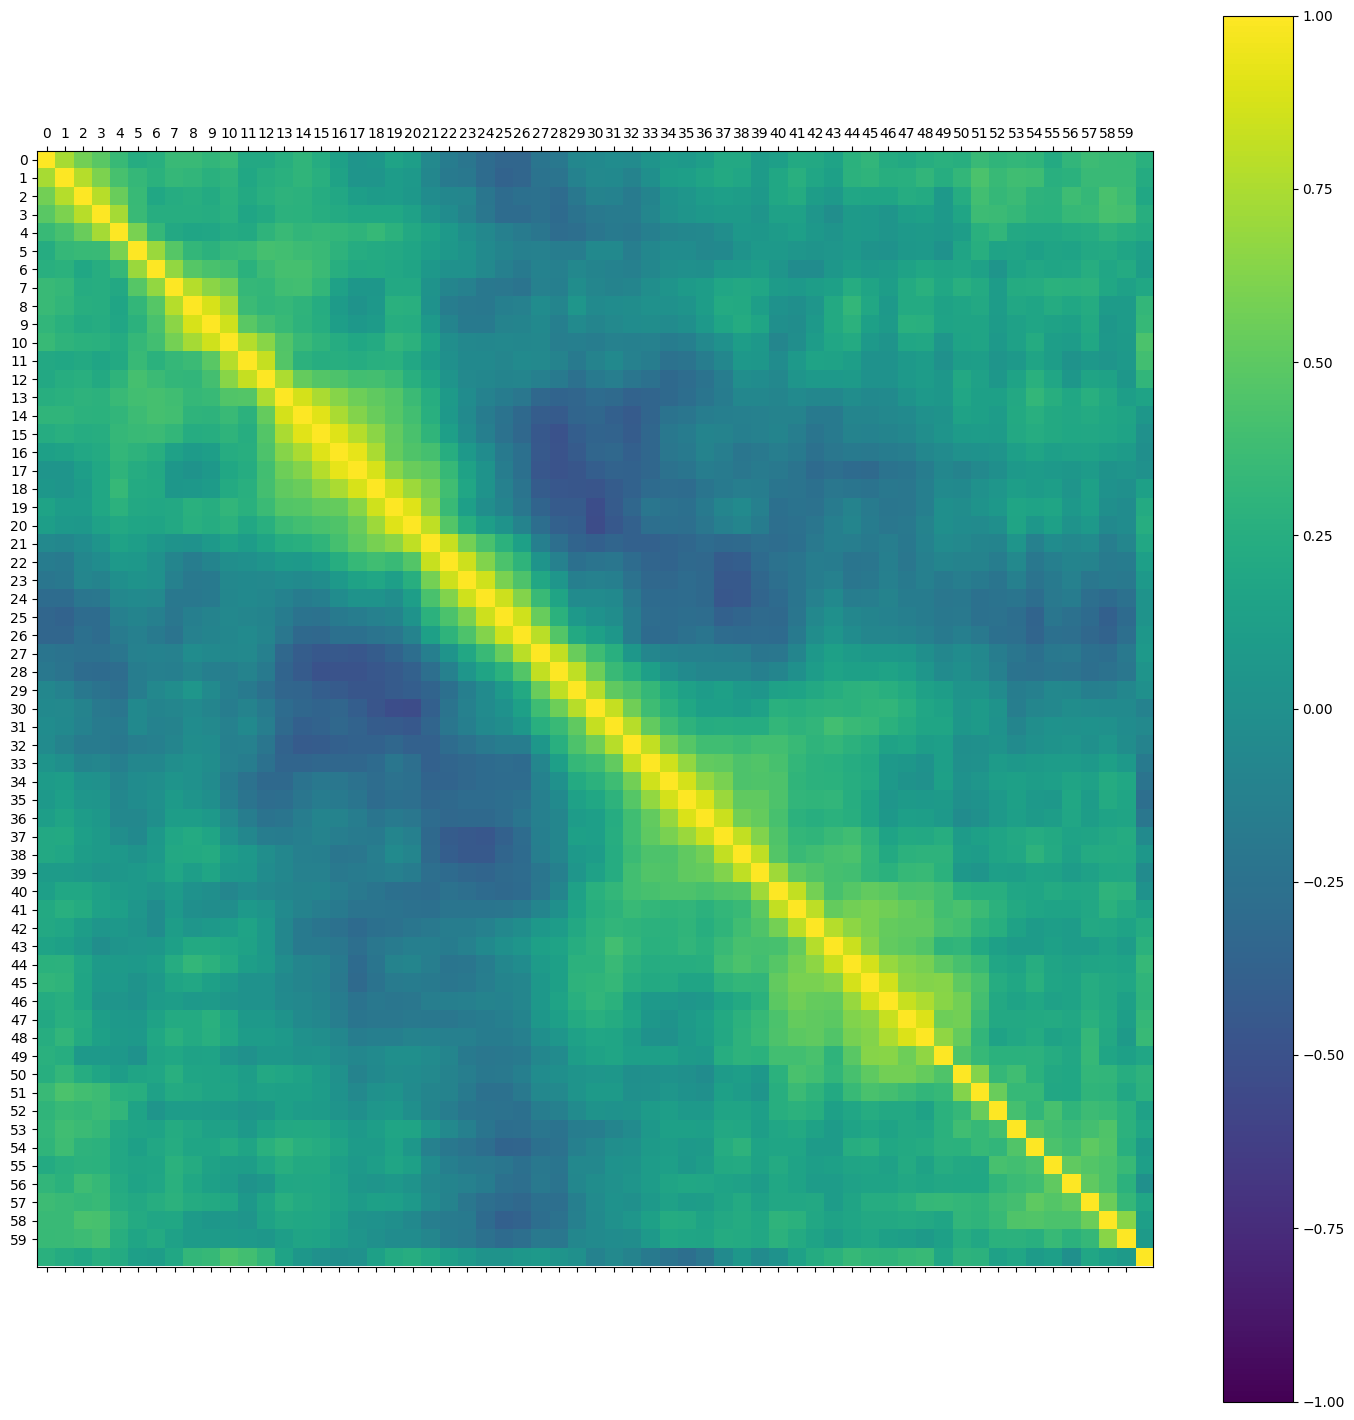

In [9]:
correlations = df.corr('pearson')

fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = np.arange(0, 60, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

Похоже, что в порядке атрибутов также есть некоторая структура. Атрибуты, которые находятся рядом друг с другом, как правило, более коррелируют друг с другом.

Так как в данных 60 признаков, то нормально визуализировать это можно только с помощью уменьшения размерности. Воспользуемся методом PCA и t-SNE

In [10]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.drop(['Label'], axis=1))

In [11]:
X = data_scaled
y = df['Label']

In [12]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)

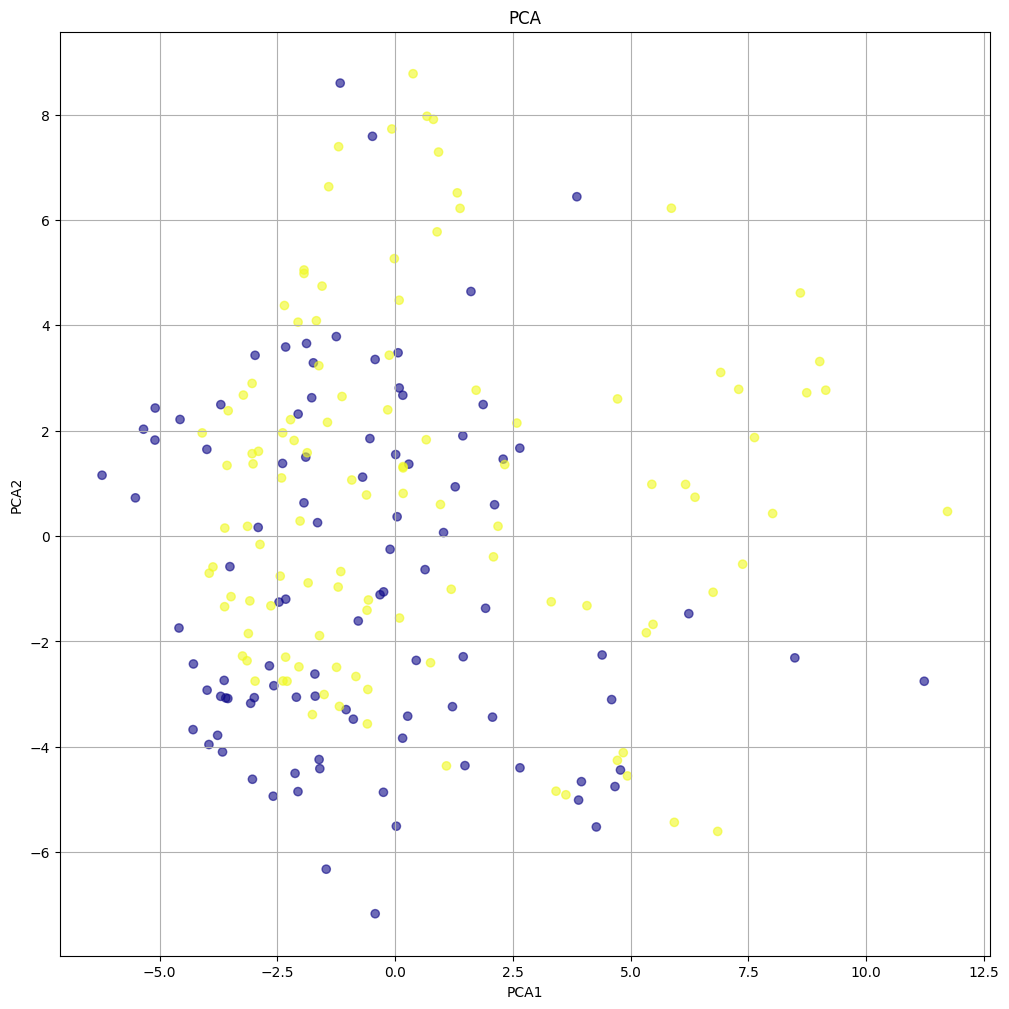

In [14]:
plt.figure(figsize=(12, 12))
plt.scatter(x=pca_result[:, 0], y=pca_result[:, 1], c=y, alpha=0.6, cmap=plt.cm.get_cmap('plasma'))
plt.title("PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.grid()
plt.show()

In [16]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
tsne_result = tsne.fit_transform(X)

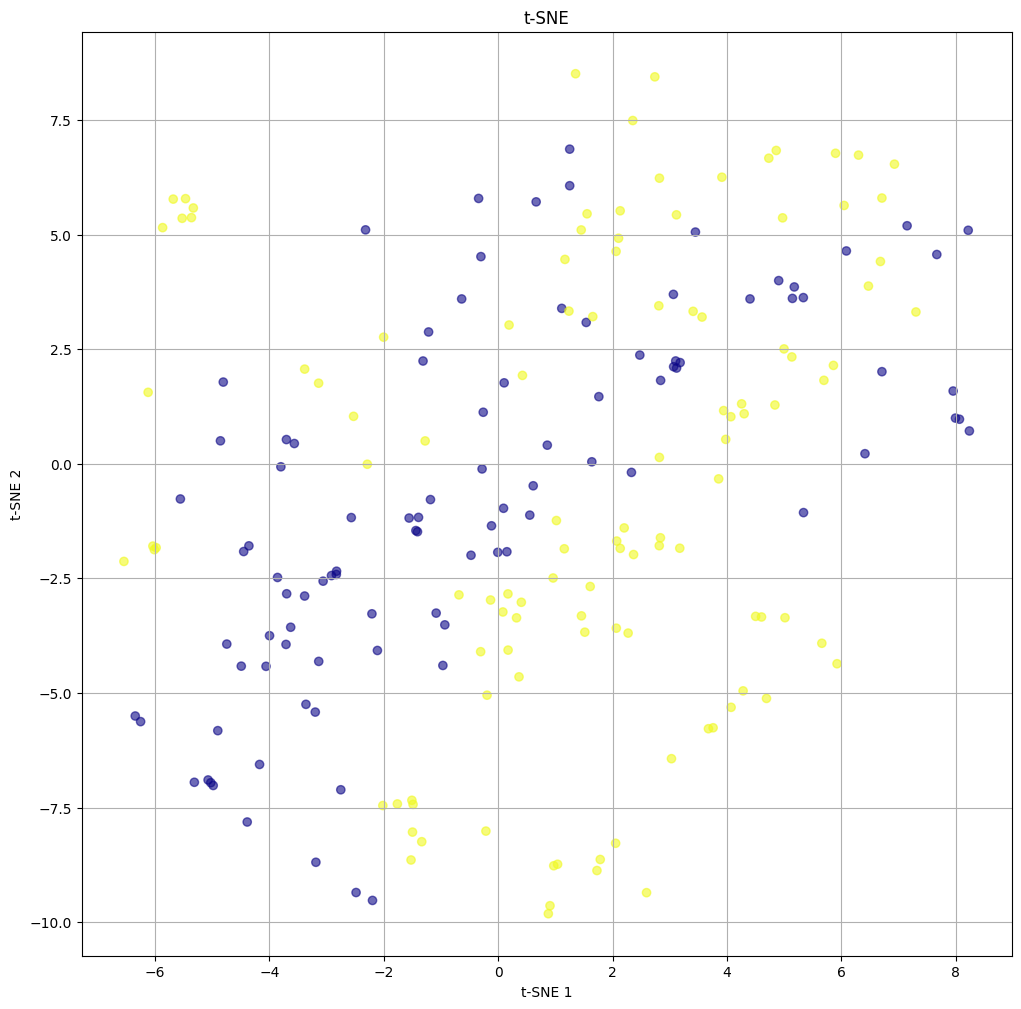

In [17]:
plt.figure(figsize=(12, 12))
plt.scatter(x=tsne_result[:, 0], y=tsne_result[:, 1], alpha=0.6, c=y, cmap=plt.cm.get_cmap('plasma'))
plt.title("t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid()
plt.show()

Из визуализаций видно, что объекты одного класса не кучкуются в одном месте, а все перемешаны между собой. Поэтому задача кластеризации на данном датасете может быть довольно сложна.

## K-Means и DBSCAN

#### Попробуем сначала обучить KMeans и DBSCAN из библиотеки sklearn

Значение k нам заранее известно, так как в датасете всего два класса

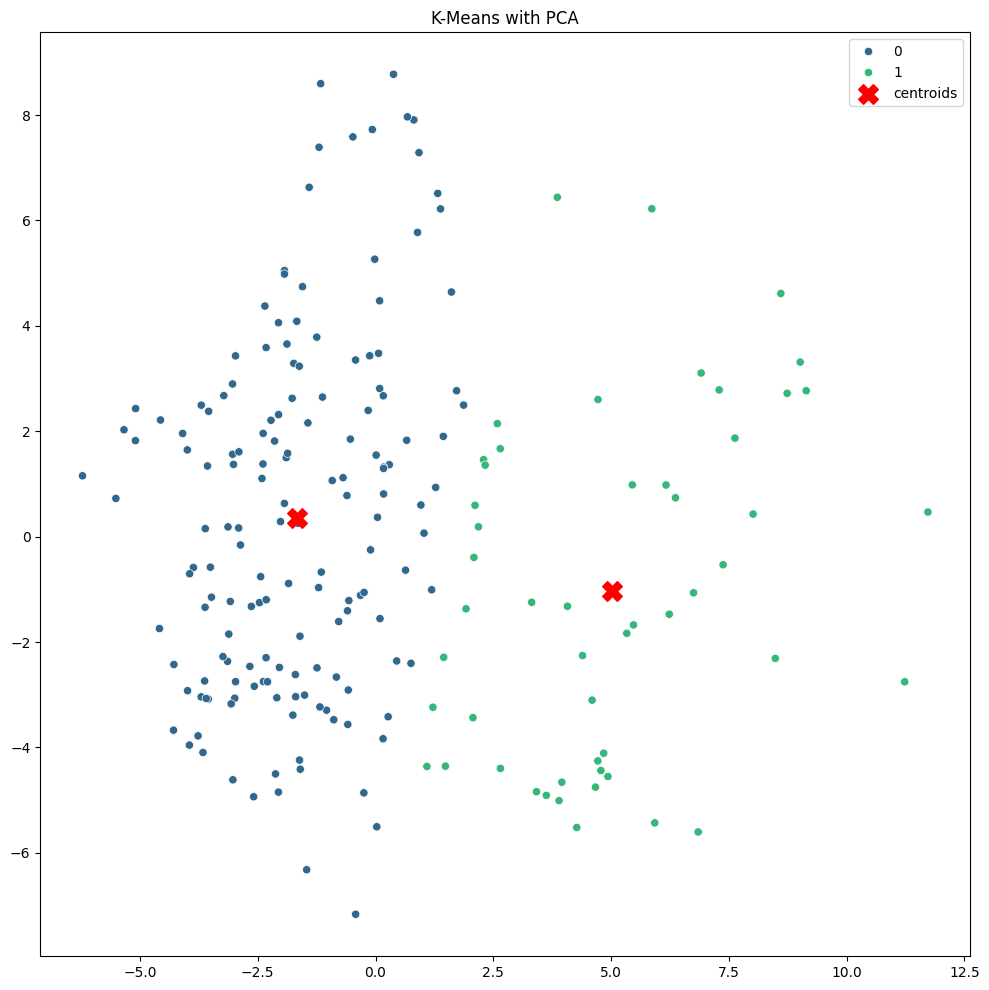

In [19]:
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(pca_result)

plt.figure(figsize=(12, 12))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='X', s=200, c='red', label='centroids')
plt.title('K-Means with PCA')
plt.legend()
plt.show()

In [21]:
silhouette_score(pca_result, labels), calinski_harabasz_score(pca_result, labels)

(np.float64(0.40734525704739855), np.float64(121.7458025211844))

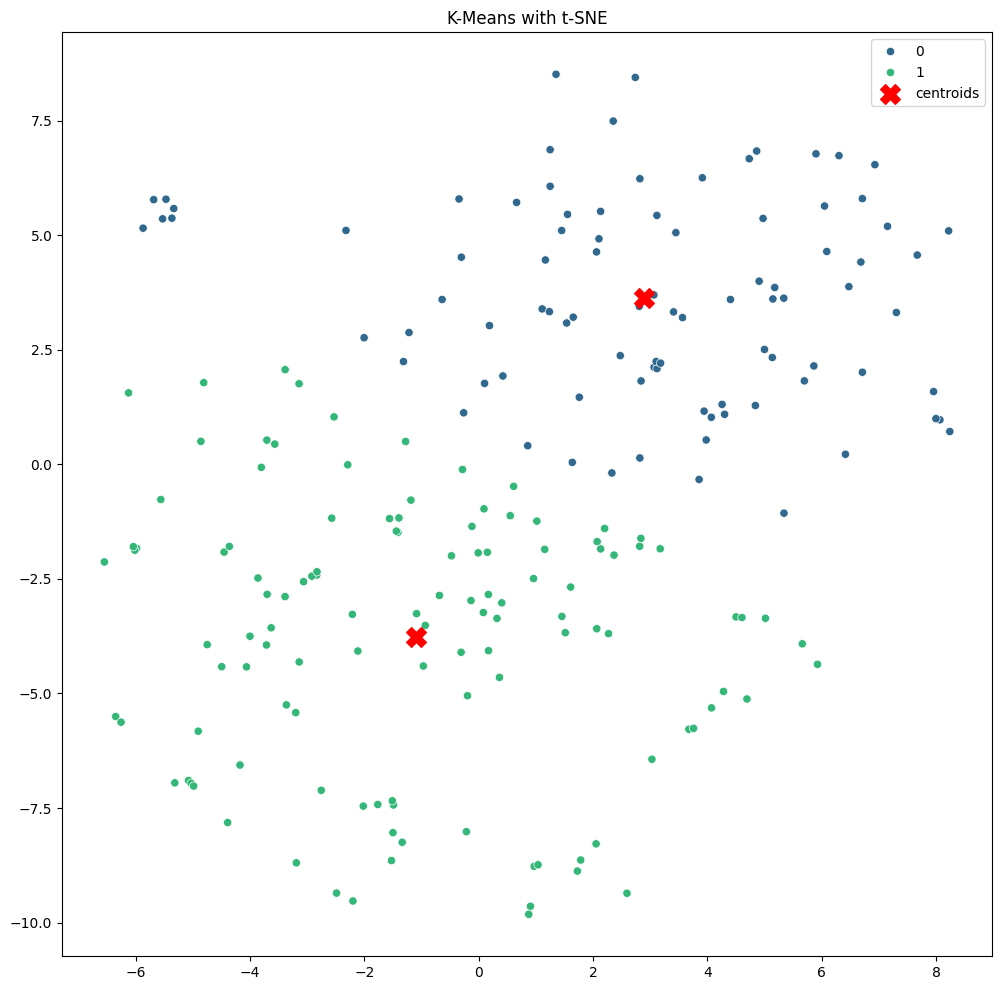

In [23]:
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(tsne_result)

plt.figure(figsize=(12, 12))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            marker='X', s=200, c='red', label='centroids')
plt.title('K-Means with t-SNE')
plt.legend()
plt.show()

In [24]:
silhouette_score(tsne_result, labels), calinski_harabasz_score(tsne_result, labels)

(np.float32(0.43907115), np.float32(211.54422))

По метрикам можно заметить, что кластеризация на данном датасете довольно не простая задача, как и ожидалось

Попробуем DBSCAN и **подберем гиперпараметры eps и min_samples**

In [88]:
epsilons = [0.01, 0.5, 1.0, 10.0]
min_samples = [5, 10, 15, 30, 50, 100]

In [99]:
best = 0
best_clusters = None

for eps in epsilons:
    for min_sample in min_samples:
        print(f"params: eps {eps}, min_samples: {min_sample}")
        dbscan = DBSCAN(eps=eps, min_samples=min_sample, metric='euclidean')
        labels = dbscan.fit_predict(pca_result)

        unique_clusters = set(labels) - {-1}
        if len(unique_clusters) < 2:
            continue

        new_score = silhouette_score(pca_result, labels)
        print(new_score)
        if new_score > best:
            best = new_score
            best_clusters = labels
print(best)

params: eps 0.01, min_samples: 5
params: eps 0.01, min_samples: 10
params: eps 0.01, min_samples: 15
params: eps 0.01, min_samples: 30
params: eps 0.01, min_samples: 50
params: eps 0.01, min_samples: 100
params: eps 0.5, min_samples: 5
-0.3372078544920462
params: eps 0.5, min_samples: 10
params: eps 0.5, min_samples: 15
params: eps 0.5, min_samples: 30
params: eps 0.5, min_samples: 50
params: eps 0.5, min_samples: 100
params: eps 1.0, min_samples: 5
0.22919581393187244
params: eps 1.0, min_samples: 10
-0.05243743566568632
params: eps 1.0, min_samples: 15
params: eps 1.0, min_samples: 30
params: eps 1.0, min_samples: 50
params: eps 1.0, min_samples: 100
params: eps 10.0, min_samples: 5
params: eps 10.0, min_samples: 10
params: eps 10.0, min_samples: 15
params: eps 10.0, min_samples: 30
params: eps 10.0, min_samples: 50
params: eps 10.0, min_samples: 100
0.22919581393187244


DBSCAN не работает по принципу "передаем гиперпараметр", он сам ищет количество кластеров. Поэтому иногда адекватно метрику посчитать не получается, так как для расчета `silhouette_score()` нужно как минимум 2 кластера (а DBSCAN может вернуть один кластер), поэтому в коде выше мы пропустили случаи, где был найден один кластер

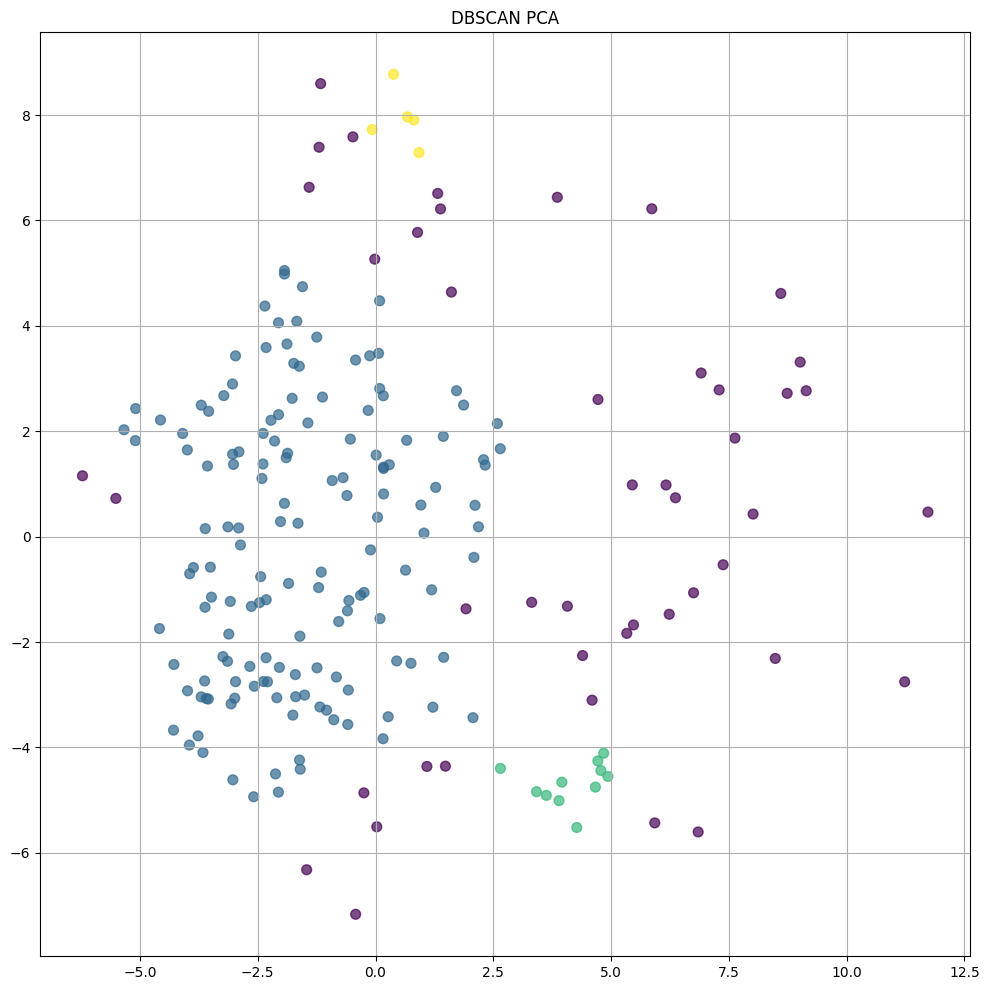

In [95]:
dbscan = DBSCAN(eps=1.0, min_samples=5, metric='euclidean')
clusters = dbscan.fit_predict(pca_result)

plt.figure(figsize=(12, 12))
plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=clusters,
    cmap='viridis',
    s=50,
    alpha=0.7
)
plt.title('DBSCAN PCA')
plt.grid(True)
plt.show()

DBSCAN вообще нашел кучу кластеров

#### Самостоятельная реализация K-Means

In [53]:
class MyKMeans:
    def __init__(self, n_clusters=2, max_iter=300, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        np.random.seed(self.random_state)
        indices = np.random.choice(len(X), self.n_clusters, replace=False)
        return X[indices]

    def _compute_distances(self, X, centroids):
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i, centroid in enumerate(centroids):
            distances[:, i] = np.linalg.norm(X - centroid, axis=1)
        return distances

    def _assign_clusters(self, distances):
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = cluster_points.mean(axis=0)
            else:
                centroids[i] = X[np.random.randint(len(X))]
        return centroids

    def fit(self, X):
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iter):
            old_centroids = self.centroids

            distances = self._compute_distances(X, old_centroids)
            new_labels = self._assign_clusters(distances)

            new_centroids = self._update_centroids(X, new_labels)

            self.centroids = new_centroids
            self.labels = new_labels

            if np.linalg.norm(old_centroids - new_centroids) < self.tol:
                break

        return self

    def predict(self, X):
        if self.centroids is None:
            raise ValueError("Model not fitted yet. Call 'fit' first.")

        distances = self._compute_distances(X, self.centroids)
        return self._assign_clusters(distances)

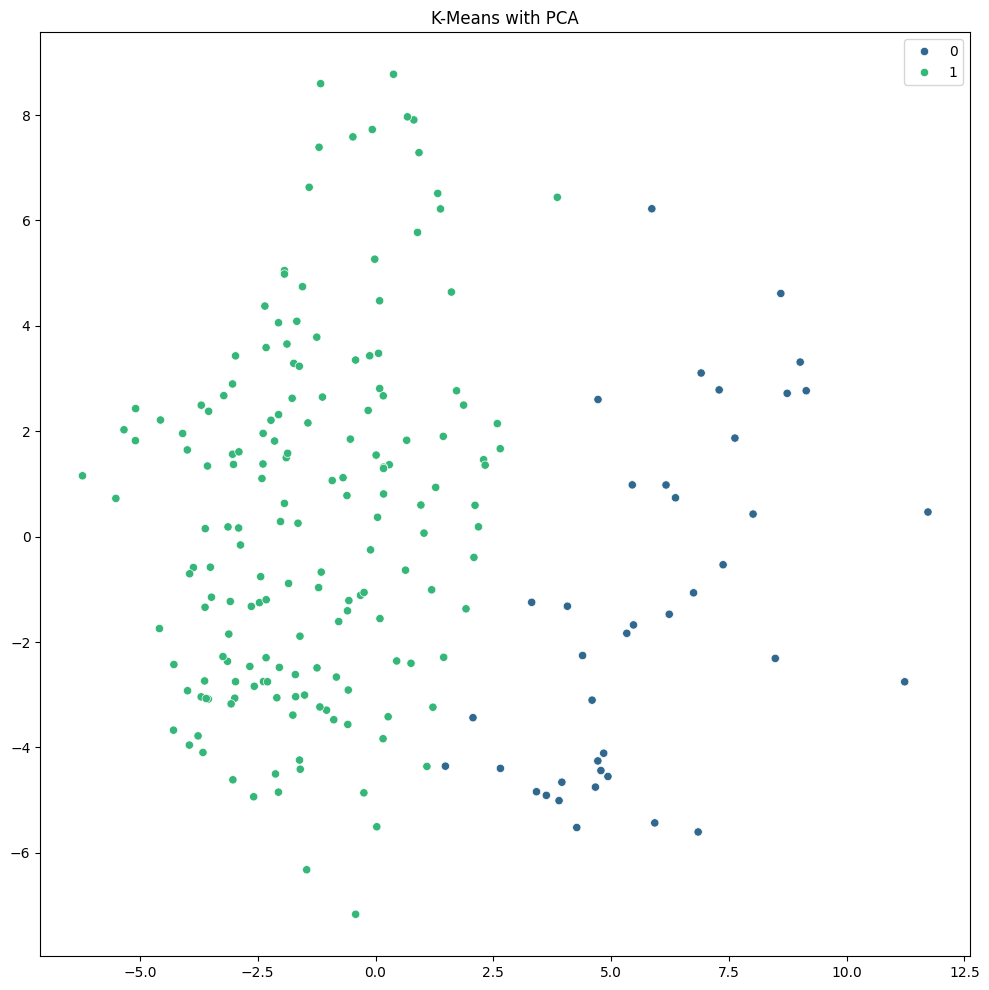

In [54]:
my_kmeans = MyKMeans()
my_kmeans.fit(pca_result)

labels = my_kmeans.predict(pca_result)

plt.figure(figsize=(12, 12))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='viridis')
plt.title('K-Means with PCA')
plt.legend()
plt.show()

In [51]:
silhouette_score(pca_result, labels), calinski_harabasz_score(pca_result, labels)

(np.float64(0.4432464224889822), np.float64(120.54330793495352))

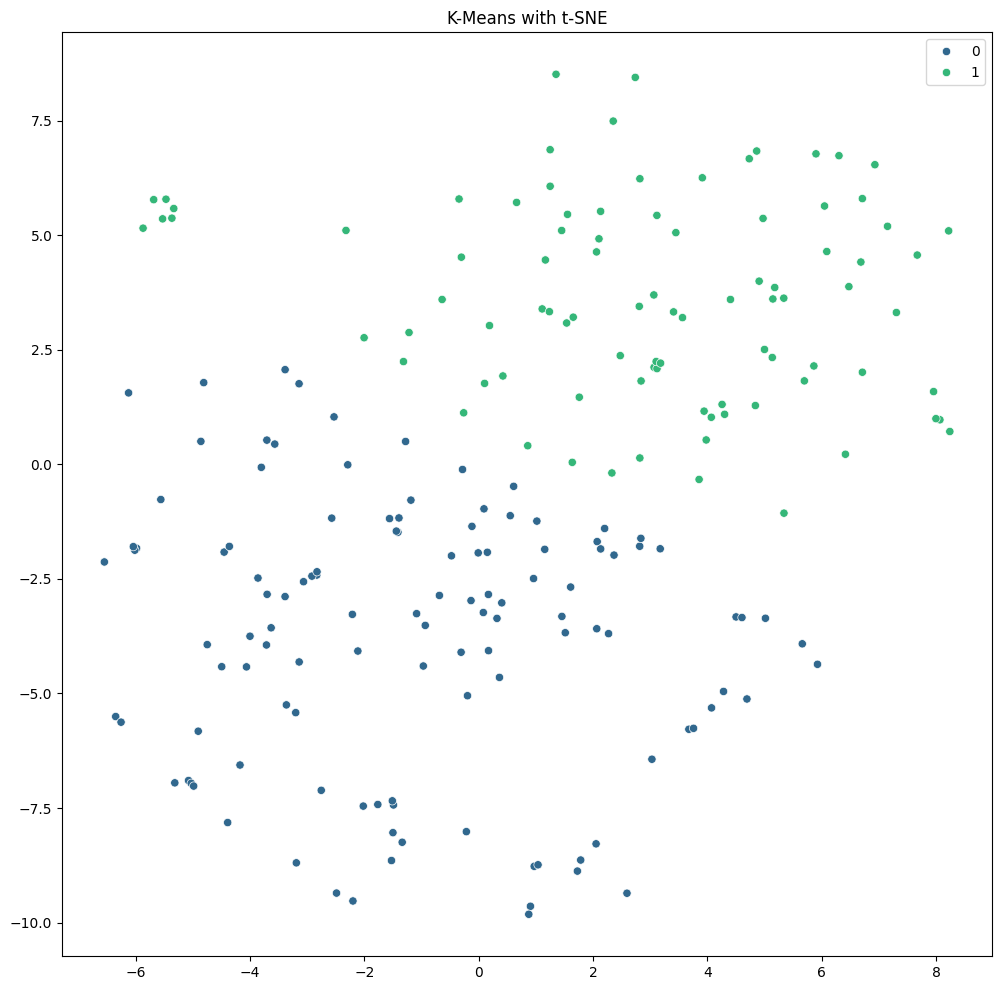

In [55]:
my_kmeans = MyKMeans()
my_kmeans.fit(tsne_result)

labels = my_kmeans.predict(tsne_result)

plt.figure(figsize=(12, 12))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='viridis')
plt.title('K-Means with t-SNE')
plt.legend()
plt.show()

In [56]:
silhouette_score(tsne_result, labels), calinski_harabasz_score(tsne_result, labels)

(np.float32(0.43907115), np.float32(211.54422))

Получились довольно похожие результаты с реализацией из sklearn